In [42]:
import pandas as pd
import numpy as np
import re

from joblib import parallel_backend

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, make_scorer, log_loss

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from code.cleaner import preprocess
from code.viz import word_plot

sns.set()

In [2]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [3]:
# sentiments['product'] = sentiments['emotion_in_tweet_is_directed_at']
# sentiments['sentiment'] = sentiments['is_there_an_emotion_directed_at_a_brand_or_product']

sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [6]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [7]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [8]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [9]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [10]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

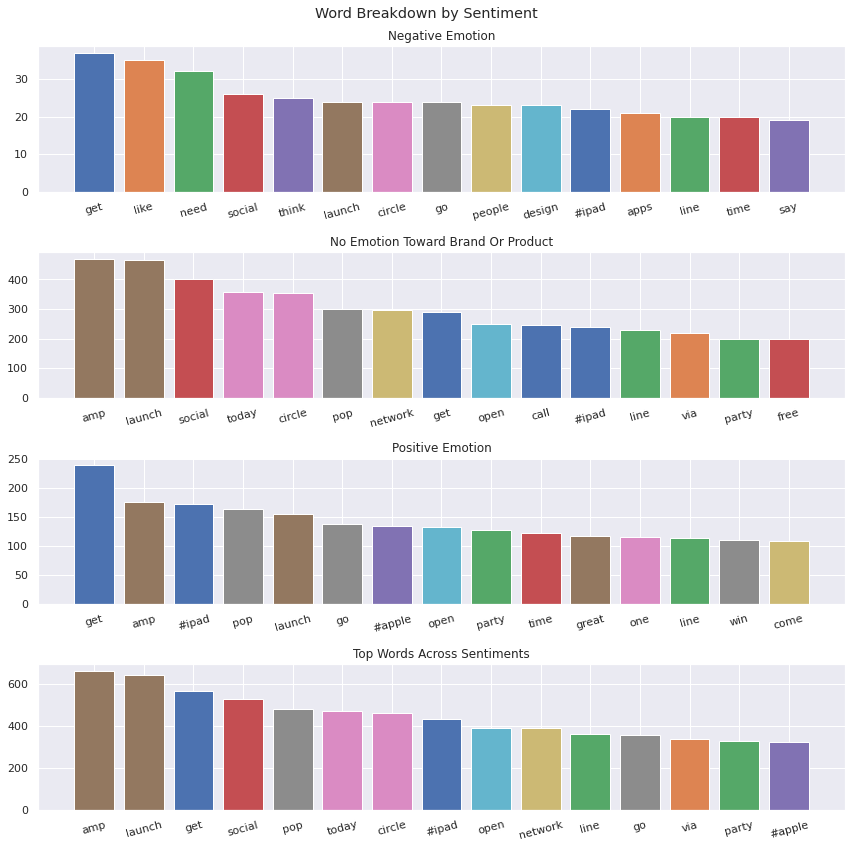

In [11]:
# train = X_train.merge(
#     y_train,left_index=True,right_index=True
#     )
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


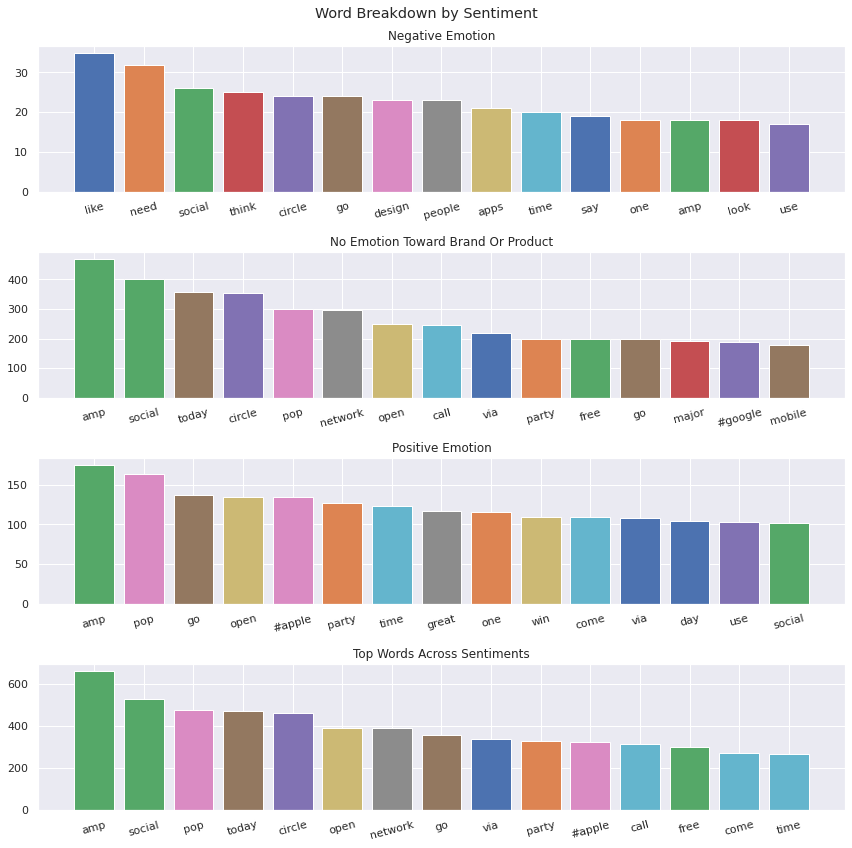

In [12]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

Index(['amp', 'go', 'social'], dtype='object')


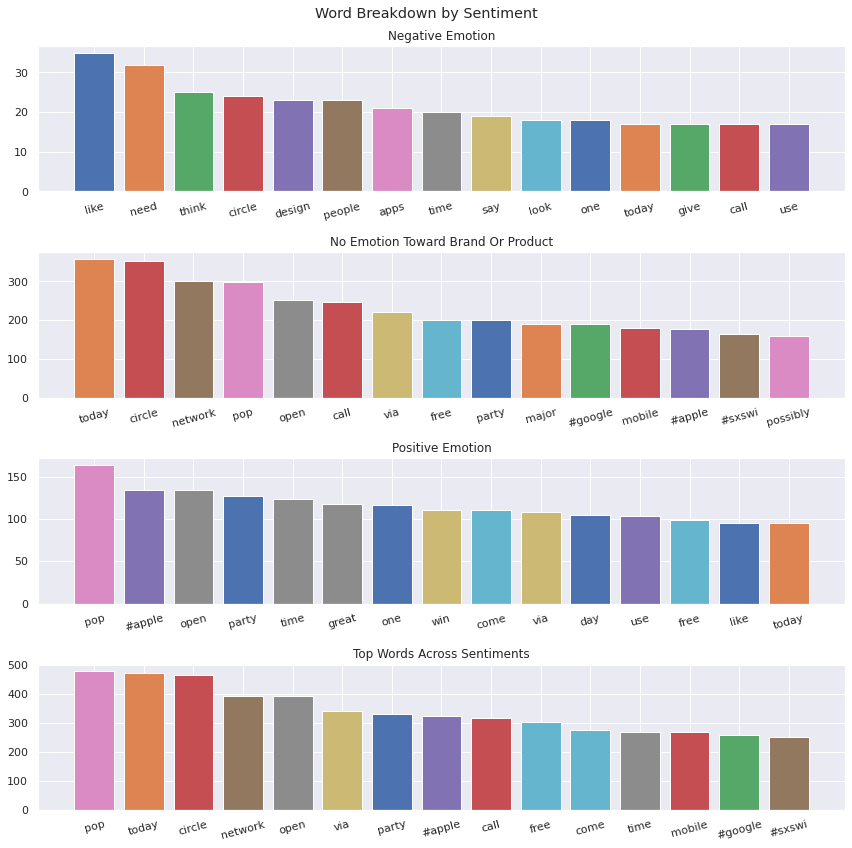

In [13]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

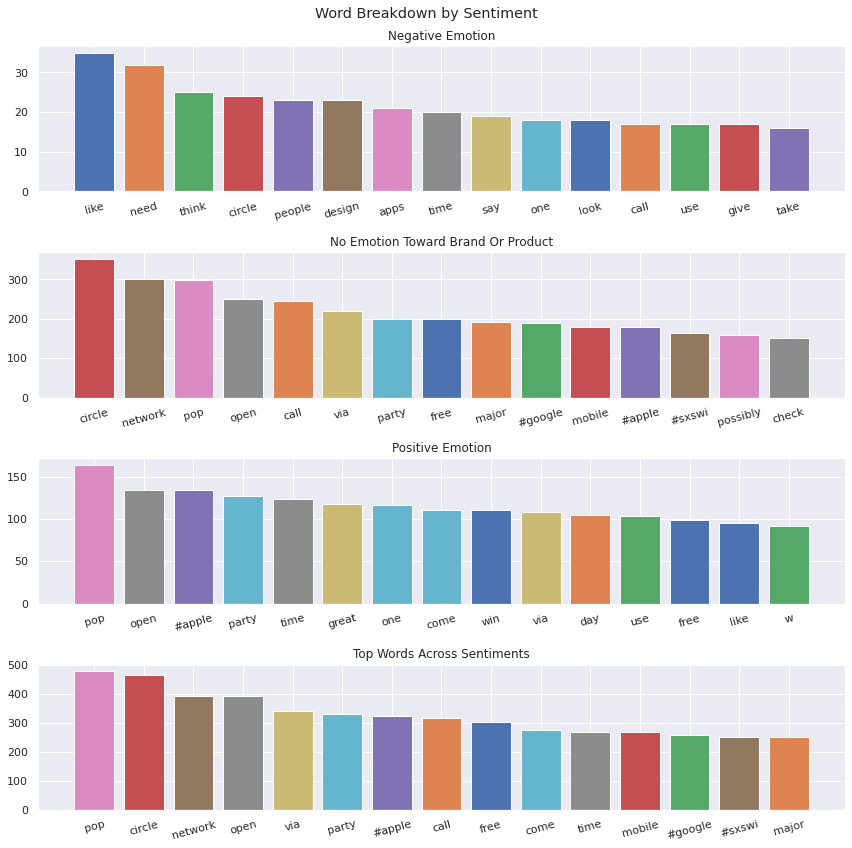

In [14]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15)
print(freq_words[1])

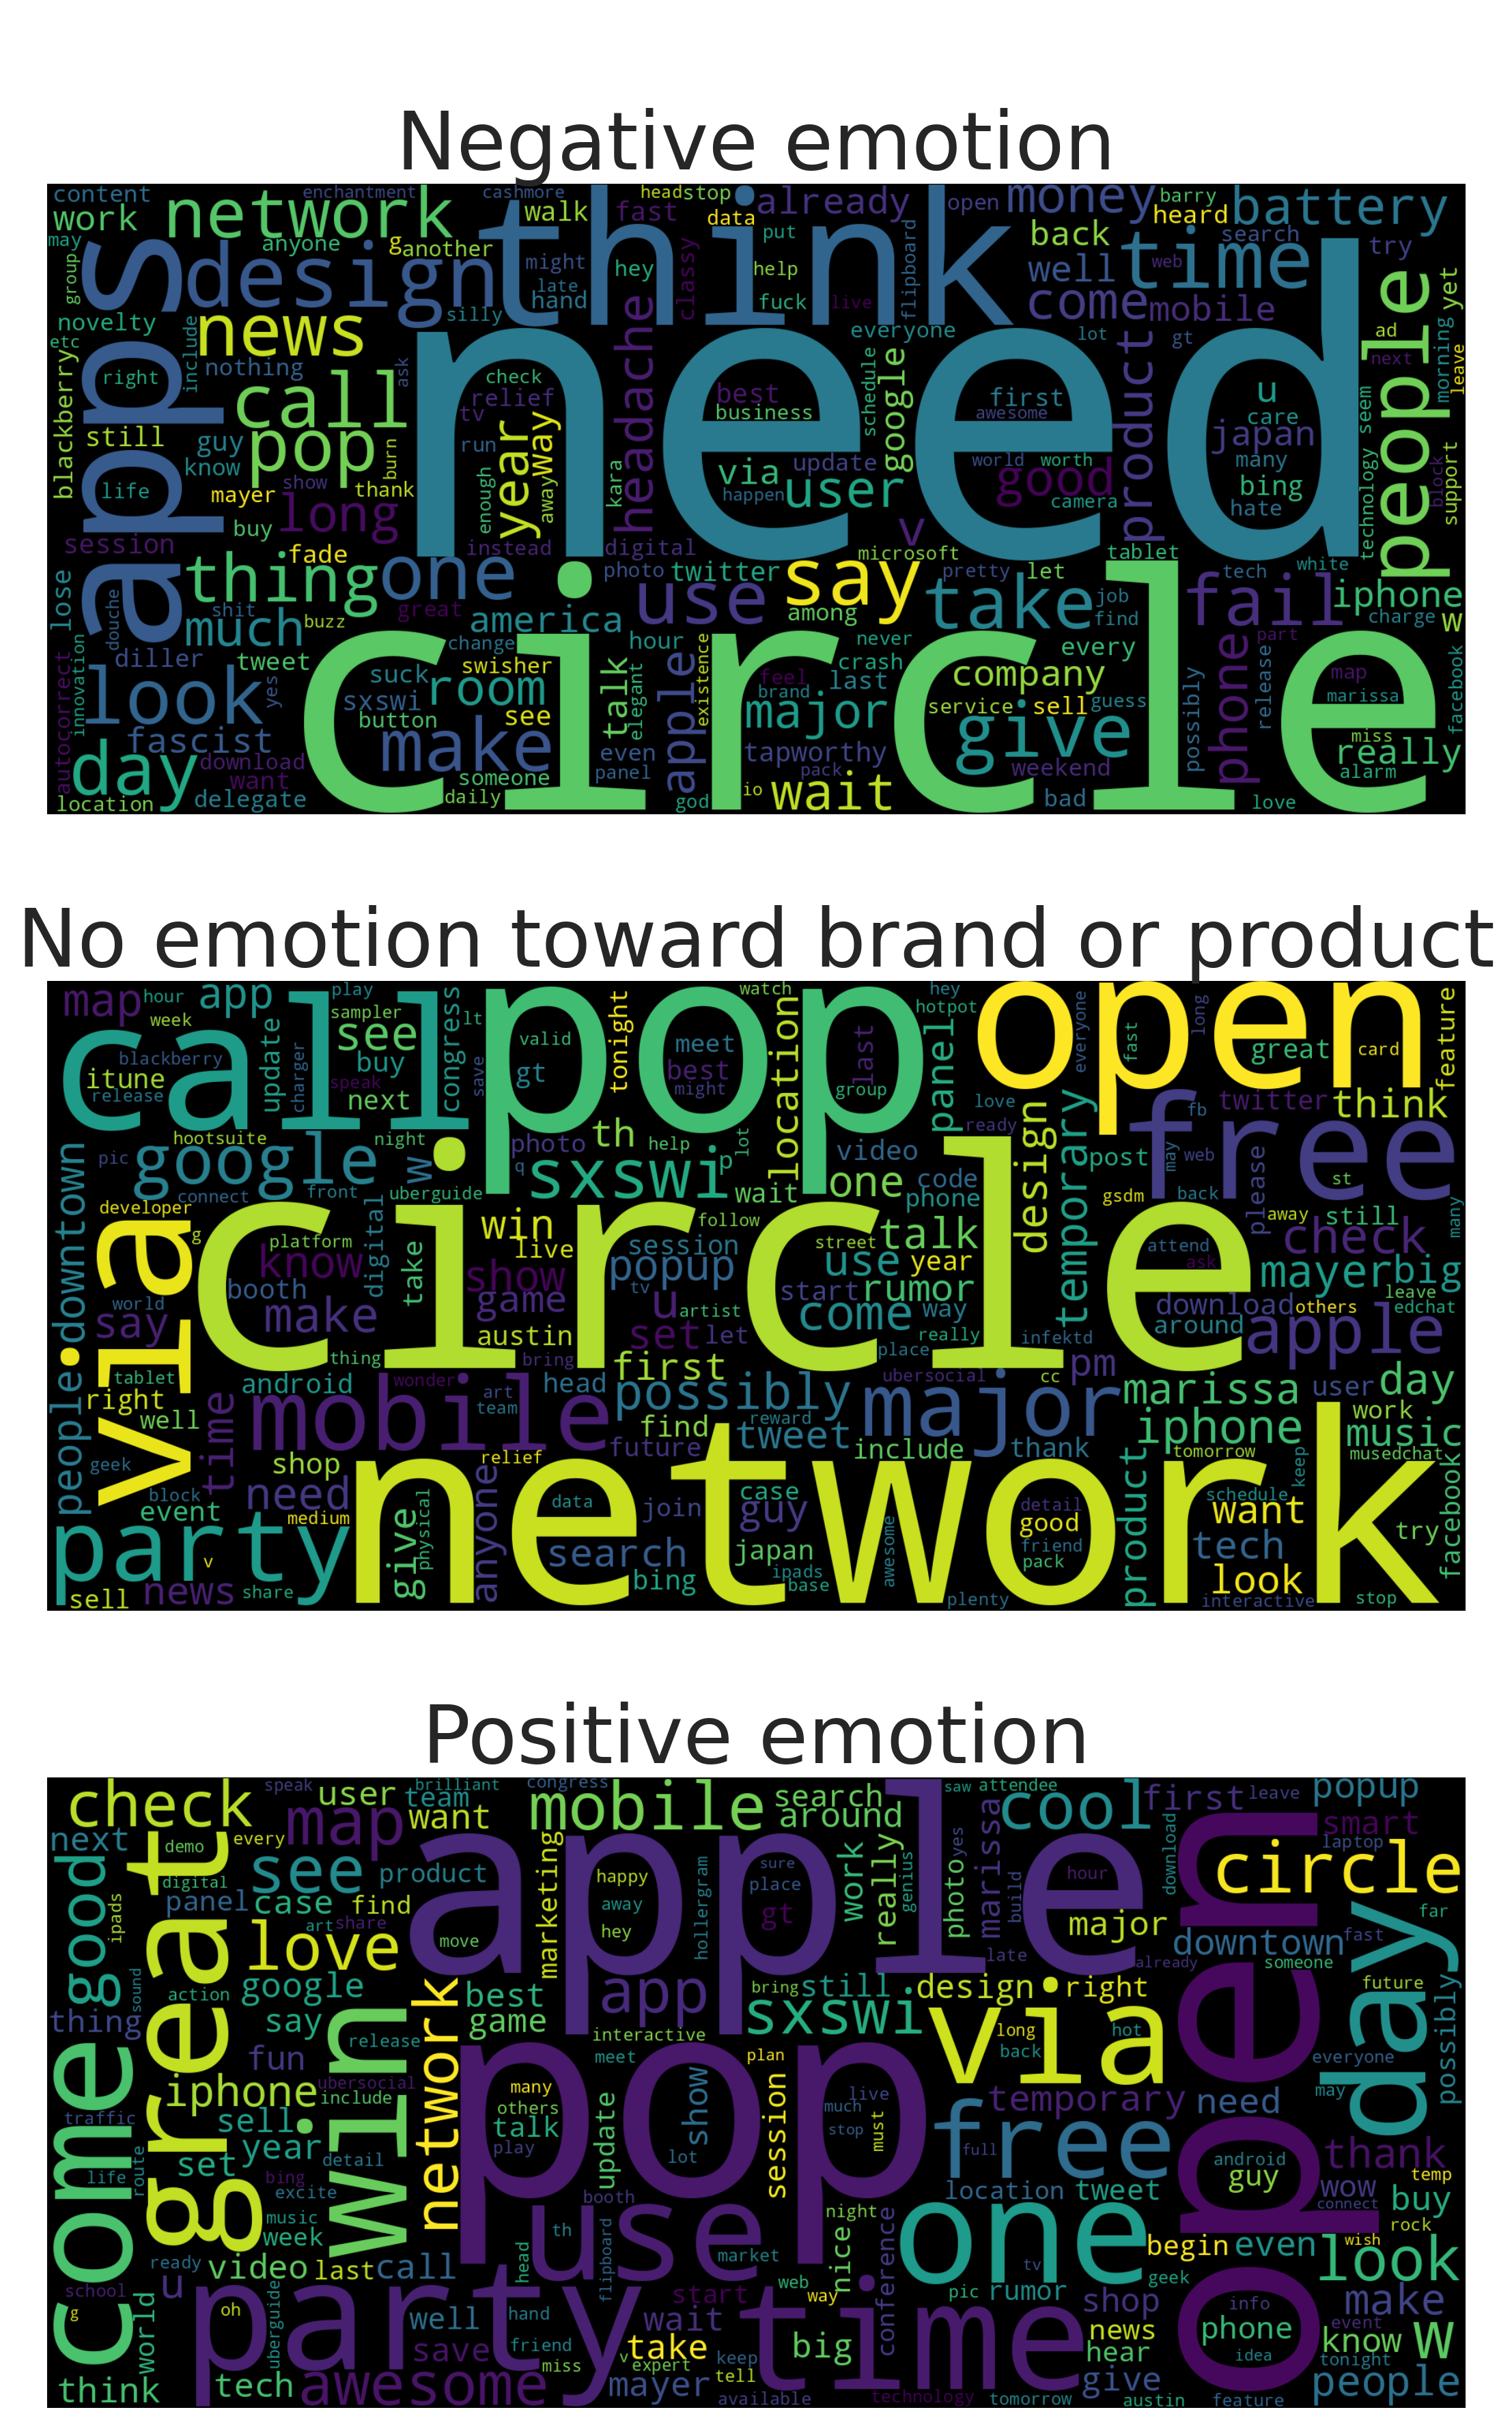

In [17]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection.

In [18]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In [19]:
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)
train_tfidf = tfidf.fit_transform(train['tokenized'])
# X = tfidf.fit_transform(sentiment_tokens)
train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())

In [52]:
rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
knc = KNeighborsClassifier(n_jobs=-2)
mnb = MultinomialNB()
svc = SVC(random_state=13)

rfc_grid = {
    'max_depth':[10,15,20,25,30],
    'min_samples_split':[10,15,20,25,30]
}
knc_grid = {
    'n_neighbors':[3,5,7,9]
}
mnb_grid = {
}
svc_grid = {
    'kernel':['poly','rbf'],
    'degree':[3,4,5]
}

rfc = GridSearchCV(
    rfc,rfc_grid
)
knc = GridSearchCV(
    knc,knc_grid
)
mnb = GridSearchCV(
    mnb,mnb_grid
)
svc = GridSearchCV(
    svc,svc_grid
)

classifiers = [rfc,knc,mnb,svc]


o = SMOTE()
pipe = imbPipeline(
    steps=[
        ('o',o),
        ('search',DummyClassifier())
    ]
)

scoring = 'f1_weighted'

grid = {
    'o':['passthrough',o],
    'search':[*classifiers]
}

In [53]:
gs = GridSearchCV(
    pipe,grid,scoring=scoring,
    verbose=3
)
# gs.fit(train_vec,train['sentiment'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.591, total=  23.8s
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.8s remaining:    0.0s


[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.582, total=  23.1s
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.0s remaining:    0.0s


[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.579, total=  23.7s
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.584, total=  24.2s
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV]  o=passthro

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 90.2min finished


GridSearchCV(estimator=Pipeline(steps=[('o', SMOTE()),
                                       ('search', DummyClassifier())]),
             param_grid={'o': ['passthrough', SMOTE()],
                         'search': [GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2,
                                                                                  random_state=13),
                                                 param_grid={'max_depth': [10,
                                                                           15,
                                                                           20,
                                                                           25,
                                                                           30],
                                                             'min_samples_split': [10,
                                                                                   15,
                                                      

In [60]:
with parallel_backend('threading',n_jobs=-2):
    gs.fit(train_vec,train['sentiment'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV] o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV] o=passt

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 23 concurrent workers.


[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.610, total=   5.4s
[CV] o=SMOTE(), search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.619, total=   5.5s
[CV] o=SMOTE(), search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}) 
[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.589, total=   5.6s[CV]  o=passthrough, search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.602, total=   5.6s
[CV] o=SMOTE(), search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_gri

[Parallel(n_jobs=-2)]: Done   9 out of  40 | elapsed:  2.3min remaining:  8.0min


[CV]  o=passthrough, search=GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-2),
             param_grid={'n_neighbors': [3, 5, 7, 9]}), score=0.559, total= 2.3min
[CV] o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}) 
[CV]  o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.540, total=  21.7s
[CV] o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}) 
[CV]  o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.544, total=  22.5s
[CV] o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}) 
[CV]  o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.563, total=  25.9s
[CV] o=SMOTE(), search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4, 5], 'kernel': ['poly', 'rbf']}) 
[CV]  o=SMOTE(), search=GridSearchCV(estimator=MultinomialNB(), param_grid={}), score=0.576, total=  20.8s
[CV] o=SMOTE(), search=Gr

[Parallel(n_jobs=-2)]: Done  23 out of  40 | elapsed: 11.6min remaining:  8.6min


[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.584, total=11.6min
[CV]  o=passthrough, search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.572, total=11.6min
[CV]  o=SMOTE(), search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30]}), score=0.575, total=12.0min
[CV]  o=SMOTE(), search=GridSearchCV(estimator=RandomForestClassifier(n_jobs=-2, random_state=13),
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [10, 15, 20, 25, 30

[Parallel(n_jobs=-2)]: Done  37 out of  40 | elapsed: 28.8min remaining:  2.3min


[CV]  o=SMOTE(), search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4, 5], 'kernel': ['poly', 'rbf']}), score=0.613, total=25.0min
[CV]  o=SMOTE(), search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4, 5], 'kernel': ['poly', 'rbf']}), score=0.643, total=25.2min
[CV]  o=SMOTE(), search=GridSearchCV(estimator=SVC(random_state=13),
             param_grid={'degree': [3, 4, 5], 'kernel': ['poly', 'rbf']}), score=0.643, total=26.9min


[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed: 29.7min finished


In [64]:
gs.best_estimator_, \
gs.best_estimator_['search'], \
gs.best_estimator_['search'].best_params_, \
gs.best_score_

(Pipeline(steps=[('o', SMOTE()),
                 ('search',
                  GridSearchCV(estimator=SVC(random_state=13),
                               param_grid={'degree': [3, 4, 5],
                                           'kernel': ['poly', 'rbf']}))]),
 GridSearchCV(estimator=SVC(random_state=13),
              param_grid={'degree': [3, 4, 5], 'kernel': ['poly', 'rbf']}),
 {'degree': 3, 'kernel': 'rbf'},
 0.6344041805732534)

In [77]:
gs.best_estimator_.steps[0][1].fit

<bound method SamplerMixin.fit of SMOTE()>

In [71]:
best_top   = gs.best_estimator_.steps[0][1]
best_inner = gs.best_estimator_['search'].best_estimator_

In [72]:
best_model = Pipeline(
    steps=[
        ('scaler',best_top),
        ('model',best_inner)
    ]
)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE()' (type <class 'imblearn.over_sampling._smote.SMOTE'>) doesn't